# Recommender Systems

In [20]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# dataset

- **./data/shared_articles.csv**
- **./data/users_interactions.csv**

## shared_articles.csv

Contains information about the articles shared in the platform. Each article has its sharing date (timestamp), the original url, title, content in plain text, the article' lang (Portuguese: pt or English: en) and information about the user who shared the article (author).

There are two possible event types at a given timestamp: 
- CONTENT SHARED: The article was shared in the platform and is available for users. 
- CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.

In [21]:
articles_df = pd.read_csv('./data/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


## users_interactions.csv

Contains logs of user interactions on shared articles. It can be joined to **articles_shared.csv** by **contentId** column.

The eventType values are:  
- **VIEW**: The user has opened the article. 
- **LIKE**: The user has liked the article. 
- **COMMENT CREATED**: The user created a comment in the article. 
- **FOLLOW**: The user chose to be notified on any new comment in the article. 
- **BOOKMARK**: The user has bookmarked the article for easy return in the future.

In [22]:
interactions_df = pd.read_csv('./data/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


## Data preprocessing

In [23]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

## Preventing *user cold-start*

In [24]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


In [25]:
print(f'# of interactions: {len(interactions_df)}')
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print(f'# of interactions from users with at least 5 interactions: {len(interactions_from_selected_users_df)}')

# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


In [26]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df.groupby(['personId', 'contentId'])['eventStrength'].sum().apply(smooth_user_preference).reset_index()
print(f'# of unique user/item interactions: {len(interactions_full_df)}')
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


# Evaluation

In [27]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df, stratify=interactions_full_df['personId'],  test_size=0.20, random_state=649846314)

print(f'# interactions on Train set: {len(interactions_train_df)}')
print(f'# interactions on Test set: {len(interactions_test_df)}')

# interactions on Train set: 31284
# interactions on Test set: 7822


In [28]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [29]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [30]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=54519835):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df), topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

# Popularity model

In [31]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [32]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)].sort_values('eventStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', left_on = 'contentId', right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]

        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [33]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print(f'\nGlobal metrics:\n{pop_global_metrics}')
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...


<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.24303247251342366, 'recall@10': 0.3697264126821785}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
2,18,44,192,0.093750,0.229167,3609194402293569455
43,13,25,134,0.097015,0.186567,-2626634673110551643
75,7,21,130,0.053846,0.161538,-1032019229384696495
39,4,12,117,0.034188,0.102564,-1443636648652872475
56,18,36,88,0.204545,0.409091,-2979881261169775358
34,9,13,80,0.112500,0.162500,-3596626804281480007
315,22,27,73,0.301370,0.369863,1116121227607581999
23,15,20,69,0.217391,0.289855,-9016528795238256703
169,18,22,69,0.260870,0.318841,692689608292948411
62,20,30,68,0.294118,0.441176,3636910968448833585


# TF-IDF

In [ ]:
# tf = number_of_words_in_corpus/num_of_documents
# idf = log(num_of_documents/num_of_documents_that_contain_this_word)
# TFIDF = tf*idf

# Cosine similarity

# Content-Based Filtering model

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fakulteta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.003,max_df=0.5,max_features=5000,stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638118 stored elements in Compressed Sparse Row format>

In [52]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    # print(type(user_item_strengths_weighted_avg), user_item_strengths_weighted_avg.shape)
    user_profile_norm = sklearn.preprocessing.normalize(np.asarray(user_item_strengths_weighted_avg))
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'].isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [53]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [54]:
# ID of someone that is a programmer: -1479311724257856983
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20], columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.298669
1,machine learning,0.256198
2,machine,0.247733
3,google,0.208999
4,data,0.177180
5,ai,0.144202
6,algorithms,0.104462
7,like,0.100728
8,people,0.081980
9,language,0.076086


In [55]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', left_on = 'contentId', right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]

        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

In [58]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print(f'\nGlobal metrics:\n{cb_global_metrics}')
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...


<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set depr

1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.1696497059575556, 'recall@10': 0.2680900025568908}


<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
2,23,33,192,0.119792,0.171875,3609194402293569455
43,18,30,134,0.134328,0.223881,-2626634673110551643
75,13,32,130,0.100000,0.246154,-1032019229384696495
39,33,50,117,0.282051,0.427350,-1443636648652872475
56,5,12,88,0.056818,0.136364,-2979881261169775358
34,16,26,80,0.200000,0.325000,-3596626804281480007
315,9,19,73,0.123288,0.260274,1116121227607581999
23,7,14,69,0.101449,0.202899,-9016528795238256703
169,10,18,69,0.144928,0.260870,692689608292948411
62,6,8,68,0.088235,0.117647,3636910968448833585


# Collaborative Filtering model

## Matrix Factorization

In [63]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', columns='contentId', values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [88]:
users_items_pivot_matrix.shape

(1140, 2937)

In [68]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1140x2937 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

# SVD

In [131]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [132]:
U.shape

(1140, 15)

In [133]:
Vt.shape

(15, 2937)

In [134]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [135]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.05370975,  0.00887852,  0.00056643, ...,  0.00236643,
        -0.00216267,  0.00079838],
       [-0.00444417,  0.0002986 ,  0.002187  , ..., -0.00059014,
         0.00168179, -0.00029254],
       [-0.02836968,  0.00682815, -0.005023  , ..., -0.0153941 ,
        -0.01079506,  0.00563492],
       ...,
       [-0.02862292,  0.00321371,  0.00521665, ..., -0.00854379,
         0.00445142,  0.00222602],
       [-0.00163382,  0.00838034,  0.01646982, ..., -0.00213713,
         0.00420871, -0.00555851],
       [ 0.005035  ,  0.00116387,  0.11039882, ..., -0.03204057,
         0.04992214,  0.00833119]])

In [136]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [137]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.167434,0.160739,0.157984,0.164103,0.160893,0.161364,0.166337,0.164614,0.162340,0.164893,...,0.164663,0.156843,0.160983,0.161480,0.157447,0.160711,0.159827,0.157955,0.161062,0.161830
-9216926795620865886,0.162273,0.161285,0.162037,0.161239,0.161353,0.161279,0.161587,0.161410,0.160749,0.162012,...,0.161697,0.163762,0.161252,0.161161,0.163558,0.161393,0.161550,0.161620,0.162215,0.161384
-9194572880052200111,0.161316,0.161502,0.160672,0.161167,0.163076,0.161426,0.164056,0.159358,0.161171,0.159871,...,0.162995,0.169209,0.161702,0.164429,0.173027,0.163028,0.162659,0.161851,0.163147,0.173961
-9192549002213406534,0.168059,0.161490,0.157417,0.160685,0.163590,0.161783,0.162960,0.169503,0.160994,0.159532,...,0.164224,0.187425,0.162584,0.159215,0.165032,0.162997,0.162049,0.160920,0.164505,0.177136
-9190737901804729417,0.163043,0.161126,0.162224,0.161182,0.161357,0.161396,0.161123,0.161392,0.159048,0.163492,...,0.162090,0.162813,0.161292,0.160978,0.157311,0.161381,0.161757,0.161271,0.162248,0.161757
-9189659052158407108,0.163461,0.161034,0.159799,0.161363,0.162475,0.161525,0.161718,0.161118,0.164349,0.161919,...,0.162957,0.175935,0.161644,0.161738,0.167539,0.162771,0.161781,0.163429,0.162471,0.170778
-9184137057748005562,0.161785,0.161248,0.161573,0.161178,0.161246,0.161269,0.161298,0.161313,0.160931,0.161871,...,0.161483,0.162310,0.161231,0.161088,0.160711,0.161249,0.161485,0.161368,0.161881,0.161011
-9176143510534135851,0.164959,0.160867,0.160318,0.161153,0.160840,0.161594,0.161269,0.162234,0.170721,0.164358,...,0.161910,0.168639,0.160789,0.161441,0.165794,0.160951,0.161629,0.164758,0.161917,0.163140
-9171475473795142532,0.163423,0.161241,0.161780,0.161339,0.161365,0.161166,0.161189,0.161005,0.160152,0.162544,...,0.162091,0.163245,0.161306,0.161416,0.162154,0.161423,0.162180,0.161819,0.162562,0.161467


In [138]:
len(cf_preds_df.columns)

1140

In [140]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', left_on = 'contentId', right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [141]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...


<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set depr

1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.32689849143441574, 'recall@10': 0.4613909486064945}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
2,34,58,192,0.177083,0.302083,3609194402293569455
43,25,36,134,0.186567,0.268657,-2626634673110551643
75,14,26,130,0.107692,0.200000,-1032019229384696495
39,24,43,117,0.205128,0.367521,-1443636648652872475
56,28,43,88,0.318182,0.488636,-2979881261169775358
34,23,29,80,0.287500,0.362500,-3596626804281480007
315,25,37,73,0.342466,0.506849,1116121227607581999
23,18,21,69,0.260870,0.304348,-9016528795238256703
169,16,26,69,0.231884,0.376812,692689608292948411
62,16,24,68,0.235294,0.352941,3636910968448833585


## Hybrid Recommender

In [142]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df, how = 'outer', left_on = 'contentId', right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', left_on = 'contentId', right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df, cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

In [143]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...


<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set depr

1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.34223983635898747, 'recall@10': 0.47379186908718995}


<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
<ipython-input-30-19db58532e5d>:13: DeprecationWarning: Sampling from a set depr

,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
2,37,56,192,0.192708,0.291667,3609194402293569455
43,25,38,134,0.186567,0.283582,-2626634673110551643
75,16,29,130,0.123077,0.223077,-1032019229384696495
39,25,44,117,0.213675,0.376068,-1443636648652872475
56,28,42,88,0.318182,0.477273,-2979881261169775358
34,22,30,80,0.275000,0.375000,-3596626804281480007
315,25,37,73,0.342466,0.506849,1116121227607581999
23,18,22,69,0.260870,0.318841,-9016528795238256703
169,15,25,69,0.217391,0.362319,692689608292948411
62,15,24,68,0.220588,0.352941,3636910968448833585


## Comparing the methods

In [144]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.169650,0.268090
Popularity,0.243032,0.369726
Collaborative Filtering,0.326898,0.461391
Hybrid,0.342240,0.473792


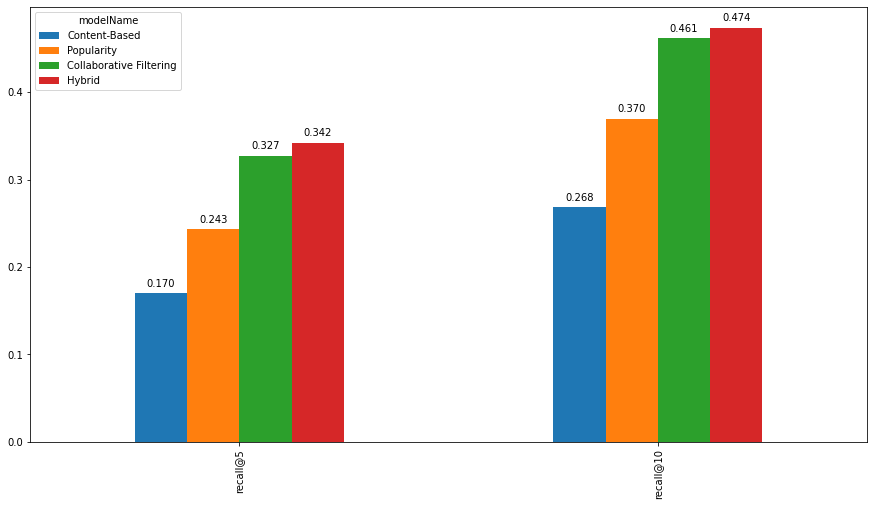

In [145]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

In [146]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

In [147]:
# id of some programmer: -1479311724257856983
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
3,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
98,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
38,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
6,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
73,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
39,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
56,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
94,3.643856,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
108,3.523562,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
27,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en


In [149]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,29.490582,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
1,29.163625,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
2,28.946352,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
3,28.427149,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
4,28.056693,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
5,27.616883,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
6,27.543657,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
7,27.462305,4118743389464105405,Why Google App Engine rocks: A Google engineer...,https://cloudplatform.googleblog.com/2016/04/w...,en
8,27.368156,-1901742495252324928,Designing smart notifications,https://medium.com/@intercom/designing-smart-n...,en
9,27.055239,3320201327008235211,How Mark Zuckerberg Led Facebook's War to Crus...,http://www.vanityfair.com/news/2016/06/how-mar...,en
